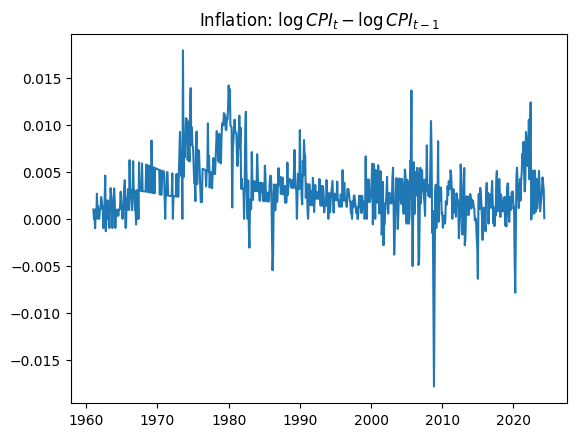

In [1]:
## Inflation Forecast
## Target variable: Month over Month inflation
import os
import time
import pickle
import sqlite3
import numba
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from functions import get_data
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
import sqlite3
import random
import xgboost as xgb
import tensorflow as tf
seed=42
# Transform:
# Transformation = 'No Transform'
Transformation = 'Transform'
# :Transforms according to the recommendations given by McCracken and Ng (2015) for all but Group 7 (Prices),
#  which are transformed as year over year growth

Target = 'Inflation MoM'

price_var = ['WPSFD49207', 'WPSFD49502', 'WPSID61', 'WPSID62', 'OILPRICEx', 'PPICMM', 'CPIAUCSL', 
             'CPIAPPSL', 'CPITRNSL', 'CPIMEDSL', 'CUSR0000SAC', 'CUSR0000SAD', 'CUSR0000SAS', 
             'CPIULFSL', 'CUSR0000SA0L2', 'CUSR0000SA0L5', 'PCEPI', 'DDURRG3M086SBEA', 'DNDGRG3M086SBEA', 'DSERRG3M086SBEA']

lags = 1
X_used, Y_used, Date_used = get_data(Transformation, lags)

n = X_used.shape[0]

forecast_period = pd.to_datetime('2015-01-01')<=Date_used
forecast_idx = np.where(forecast_period)[0]
n_test = np.sum(forecast_period)

validation_period = (pd.to_datetime('2005-08-01')<=Date_used) & (pd.to_datetime('2015-01-01') > Date_used)
validation_idx = np.where(validation_period)[0]
n_val = np.sum(validation_period)

training_period = pd.to_datetime('2005-08-01')>Date_used
training_idx = np.where(training_period)[0]
n_train = np.sum(training_period)

X_train = X_used.loc[training_period,:]
Y_train = Y_used.loc[training_period]

X_val = X_used.loc[validation_period,:]
Y_val = Y_used.loc[validation_period]

X_test = X_used.loc[forecast_period,:]
Y_test = Y_used.loc[forecast_period]

nnan_idx = np.sum(np.isnan(X_used), axis=0)==0
X_used_nnan = X_used.loc[:,nnan_idx]

X_train_nnan = X_used_nnan.loc[training_period,:]
X_val_nnan = X_used_nnan.loc[validation_period,:]
X_test_nnan = X_used_nnan.loc[forecast_period,:]


plt.plot(pd.to_datetime(Date_used),Y_used)
plt.title("Inflation: $\log CPI_t-\log CPI_{t-1}$")
plt.show()

In [2]:
#######################################################################################
################################   AR(1), AR(12)  #####################################
#######################################################################################
OLS = LinearRegression(fit_intercept=True)
OLS.fit(X_train[['CPIAUCSL']], Y_train)
# OLS.coef_

Y_hat = OLS.predict(X_test[['CPIAUCSL']])
RMSE_AR1 = np.sqrt(np.mean((Y_test-Y_hat)**2))

OLS = LinearRegression(fit_intercept=True)
OLS.fit(X_train[['CPIAUCSL','CPIAUCSL_lag11']], Y_train)
# OLS.coef_

Y_hat = OLS.predict(X_test[['CPIAUCSL','CPIAUCSL_lag11']])
RMSE_AR1_12 = np.sqrt(np.mean((Y_test-Y_hat)**2))

lags_label = np.append(['CPIAUCSL'],['CPIAUCSL_lag%i' % p for p in range(1,12)])

OLS = LinearRegression(fit_intercept=True)
OLS.fit(X_train[lags_label], Y_train)
# OLS.coef_

Y_hat = OLS.predict(X_test[lags_label])
RMSE_AR12 = np.sqrt(np.mean((Y_test-Y_hat)**2))

print('The RMSE of AR1 model is %f'%RMSE_AR1)
print('The RMSE of AR12 model is %f'%RMSE_AR12)
print('The RMSE of AR1_12 model is %f'%RMSE_AR1_12)

The RMSE of AR1 model is 0.002456
The RMSE of AR12 model is 0.002445
The RMSE of AR1_12 model is 0.002465


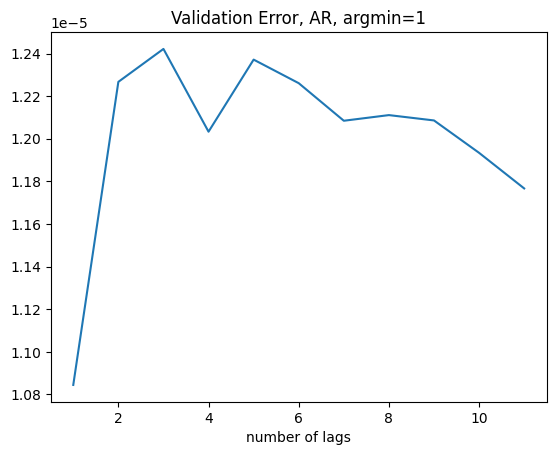

The RMSE of AR model is 0.002456


In [3]:
#######################################################################################
################################   AR, Validate  #####################################
#######################################################################################
ar_p_list = np.arange(1,12)

val_err = np.zeros((n_val, len(ar_p_list)))
AR_dict = {}
for cv_i, ar_p in enumerate(ar_p_list):

    lags_label = np.append(['CPIAUCSL'],['CPIAUCSL_lag%i' % p for p in range(1,ar_p)])

    AR_dict[cv_i] = LinearRegression(fit_intercept=True)
    AR_dict[cv_i].fit(X_train[lags_label], Y_train)
    # OLS.coef_

    Y_hat = AR_dict[cv_i].predict(X_val[lags_label])
    val_err[:, ar_p-1] = Y_val.values-Y_hat

min_idx = np.argmin(np.mean(np.array(val_err)**2, axis=0))
val_err_AR = np.mean(np.array(val_err)**2, axis=0)

plt.plot(ar_p_list,val_err_AR)
plt.xlabel('number of lags')
plt.title('Validation Error, AR, argmin=%i'%ar_p_list[min_idx])
plt.show()

lags_label = np.append(['CPIAUCSL'],['CPIAUCSL_lag%i' % p for p in range(1,ar_p_list[min_idx])])

Y_hat = AR_dict[min_idx].predict(X_test[lags_label])
test_err_AR = Y_test.values - Y_hat
RMSE_AR = np.sqrt(np.sum(test_err_AR**2)/len(test_err_AR))
print('The RMSE of AR model is %f'%RMSE_AR)

In [4]:
#######################################################################################
################################   Random Walk  #######################################
#######################################################################################
Y_hat = X_test['CPIAUCSL']
RMSE_RW = np.sqrt(np.mean((Y_test-Y_hat)**2))
print('The RMSE of RW model is %f'%RMSE_RW)

The RMSE of RW model is 0.002753


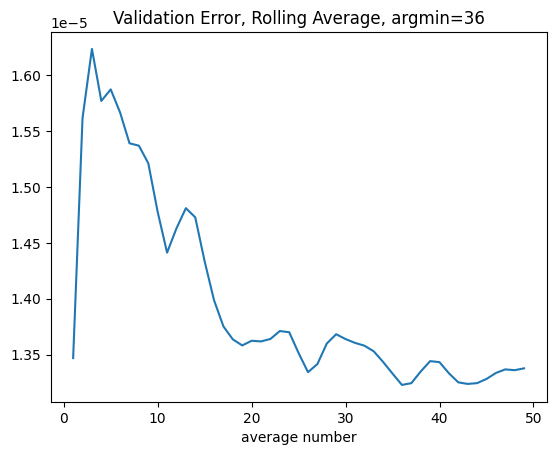

The RMSE of RA model is 0.002886


In [5]:
#######################################################################################
################################   Rolling Average  ###################################
#######################################################################################
average_n_list = np.arange(1,50,1)

val_err = np.zeros((n_val, len(average_n_list)))
Y_long = pd.concat((Y_train, Y_val),axis=0)
for i in range(len(Y_val)):
    for cv_i, average_n in enumerate(average_n_list):
        Y_hat = np.mean(Y_long.iloc[i+n_train-average_n:i+n_train])
        val_err[i, cv_i] = Y_val.iloc[i] - Y_hat

min_idx = np.argmin(np.mean(np.array(val_err)**2, axis=0))
val_err_RA = np.mean(np.array(val_err)**2, axis=0)

plt.plot(average_n_list, val_err_RA)
plt.xlabel('average number')
plt.title('Validation Error, Rolling Average, argmin=%s'%str(average_n_list[min_idx]))
plt.show()

average_n = average_n_list[min_idx]
test_err_RA = np.zeros((n_test,))
Y_long = pd.concat((Y_val, Y_test), axis=0)
Y_hat = np.zeros((n_test,))
for i in range(len(Y_test)):
    Y_hat[i] = np.mean(Y_long.iloc[i+n_val-average_n:i+n_val])
    test_err_RA[i] = Y_test.iloc[i] - Y_hat[i]

RMSE_RA = np.sqrt(np.mean(np.array(test_err_RA)**2, axis=0))
print('The RMSE of RA model is %f'%RMSE_RA)

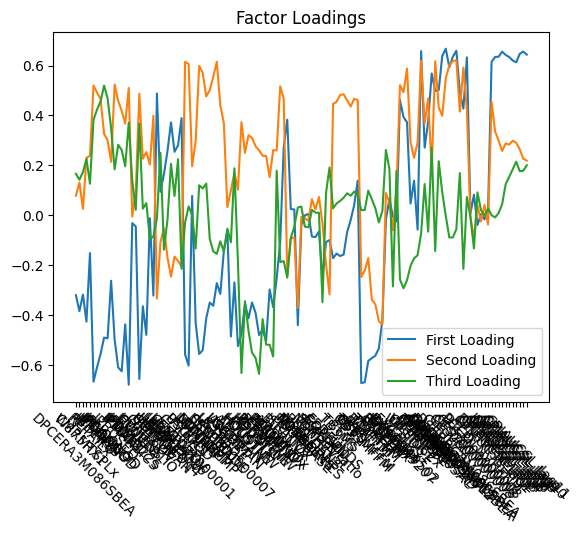

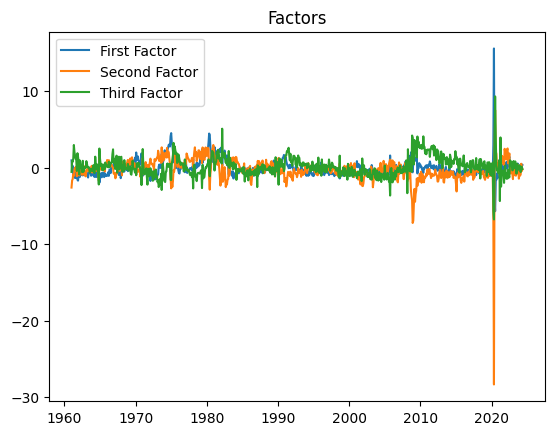

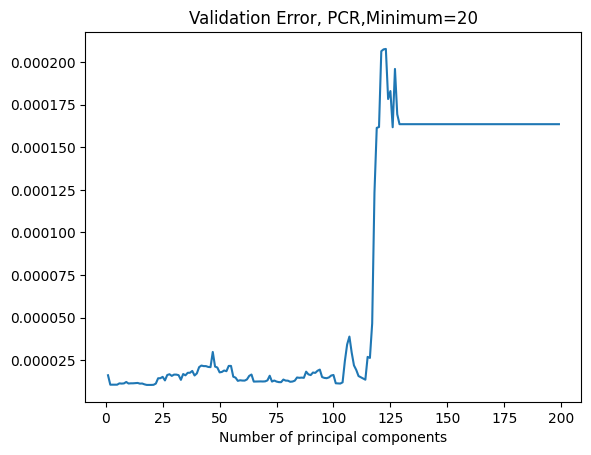

The RMSE of PCR is 0.002326


In [6]:
#######################################################################################
####################################   PCR    #########################################
#######################################################################################
X_train_stzd = (X_train_nnan - np.mean(X_train_nnan, axis=0))/np.std(X_train_nnan, axis = 0)
X_val_stzd = (X_val_nnan - np.mean(X_train_nnan, axis=0))/np.std(X_train_nnan, axis = 0)
X_test_stzd = (X_test_nnan - np.mean(X_train_nnan, axis=0))/np.std(X_train_nnan, axis = 0)    

Sigma_hat = X_train_stzd.T@X_train_stzd/n_train
eigval, eigvec = np.linalg.eigh(Sigma_hat)
eigval = np.real(eigval)
eigvec = np.real(eigvec)
idx = eigval.argsort()[::-1]
eigval_sorted = eigval[idx]
eigvec_sorted = eigvec[:, idx]
F_train = X_train_stzd @ eigvec_sorted
F_val = X_val_stzd @ eigvec_sorted
F_val.columns = F_train.columns
F_test = X_test_stzd @ eigvec_sorted
F_test.columns = F_test.columns


plt.plot(X_train_stzd.columns, eigvec_sorted[:,0]*np.sqrt(eigval_sorted)[0], label='First Loading')
plt.plot(X_train_stzd.columns, eigvec_sorted[:,1]*np.sqrt(eigval_sorted)[1], label='Second Loading')
plt.plot(X_train_stzd.columns, eigvec_sorted[:,2]*np.sqrt(eigval_sorted)[2], label='Third Loading')
plt.xticks(rotation=-45)
plt.title('Factor Loadings')
plt.legend()
plt.show()

plt.plot(Date_used,pd.concat((F_train.iloc[:,0],F_val.iloc[:,0],F_test.iloc[:,0]),axis=0)*(1/np.sqrt(eigval_sorted)[0]), label='First Factor')
plt.plot(Date_used,pd.concat((F_train.iloc[:,1],F_val.iloc[:,1],F_test.iloc[:,1]),axis=0)*(1/np.sqrt(eigval_sorted)[1]), label='Second Factor')
plt.plot(Date_used,pd.concat((F_train.iloc[:,2],F_val.iloc[:,2],F_test.iloc[:,2]),axis=0)*(1/np.sqrt(eigval_sorted)[2]), label='Third Factor')
plt.title('Factors')
plt.legend()
plt.show()



nfactors_list = np.arange(1,200)
val_err = np.zeros((n_val, len(nfactors_list)))
nfactors = 2
OLS_dict = {}
for cv_i, nfactors in enumerate(nfactors_list):
    OLS = LinearRegression(fit_intercept=True)
    OLS_dict[cv_i] = OLS.fit(F_train.iloc[:,:nfactors], Y_train)
    Y_hat = OLS_dict[cv_i].predict(F_val.iloc[:,:nfactors])
    val_err[:, cv_i] = Y_val.values-Y_hat

min_idx = np.argmin(np.mean(np.array(val_err)**2, axis=0))
val_err_PCR = np.mean(np.array(val_err)**2, axis=0)
PCR_nfactors = nfactors_list[min_idx]


plt.plot(nfactors_list, val_err_PCR)
plt.xlabel('Number of principal components')
plt.title('Validation Error, PCR,Minimum=%i'%nfactors_list[min_idx])
plt.show()

Y_hat = OLS_dict[min_idx].predict(F_test.iloc[:,:nfactors_list[min_idx]])
test_err_PCR = Y_test.values - Y_hat
RMSE_PCR = np.sqrt(np.sum(test_err_PCR**2)/len(test_err_PCR))
print('The RMSE of PCR is %f'%RMSE_PCR)

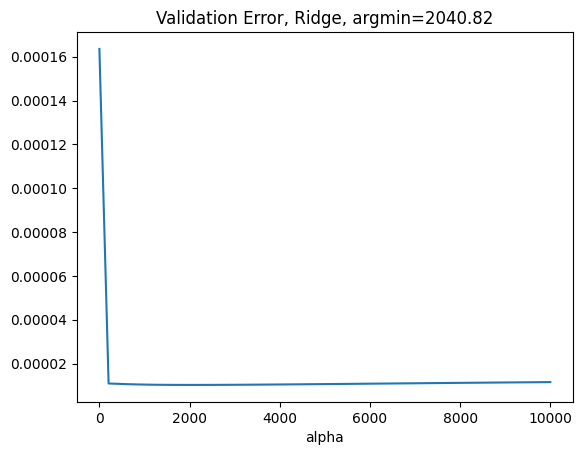

The RMSE of Ridge model is 0.002286


In [7]:
#######################################################################################
###################################   Ridge    ########################################
#######################################################################################
X_train_stzd = (X_train_nnan - np.mean(X_train_nnan, axis=0))/np.std(X_train_nnan, axis = 0)
X_val_stzd = (X_val_nnan - np.mean(X_train_nnan, axis=0))/np.std(X_train_nnan, axis = 0)
X_test_stzd = (X_test_nnan - np.mean(X_train_nnan, axis=0))/np.std(X_train_nnan, axis = 0)    

alpha_list =np.linspace(0,10000,50)
val_err = np.zeros((n_val,len(alpha_list)))
Ridgemodel_dict = {}
for cv_i, alpha in enumerate(alpha_list):
    Ridgemodel_dict[cv_i] = Ridge(alpha=alpha,fit_intercept=True, random_state=seed)
    Ridgemodel_dict[cv_i].fit(X_train_stzd, Y_train)
    Y_hat = Ridgemodel_dict[cv_i].predict(X_val_stzd) 
    val_err[:, cv_i] = Y_val.values-Y_hat

min_idx = np.argmin(np.mean(np.array(val_err)**2, axis=0))
min_idx_ridge = min_idx
val_err_Ridge = np.mean(np.array(val_err)**2, axis=0)
Ridge_alpha = alpha_list[min_idx]

plt.plot(alpha_list,val_err_Ridge)
plt.xlabel('alpha')
plt.title('Validation Error, Ridge, argmin=%0.2f'%alpha_list[min_idx])
plt.show()

Y_hat = Ridgemodel_dict[min_idx].predict(X_test_stzd)
test_err_Ridge = Y_test.values - Y_hat
RMSE_Ridge = np.sqrt(np.sum(test_err_Ridge**2)/len(test_err_Ridge))
print('The RMSE of Ridge model is %f'%RMSE_Ridge)

C:\Users\sangm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
C:\Users\sangm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\sangm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.572e-04, tolerance: 4.769e-07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers i

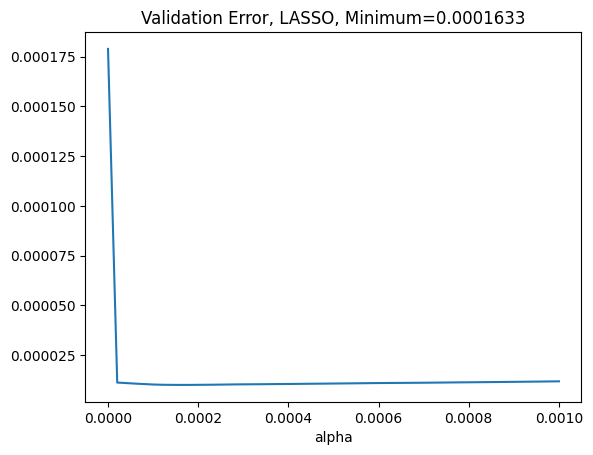

The RMSE of LASSO is 0.002253
           Variable Estimates
0   DPCERA3M086SBEA  0.000058
1         IPB51222S  0.000025
2          UEMP15OV -0.000011
3     CES1021000001  0.000006
4          USWTRADE  0.000081
5           HOUSTMW  0.000043
6            HOUSTW  0.000112
7          NONREVSL -0.000087
8          FEDFUNDS  0.000079
9               GS5  0.000085
10         TB3SMFFM -0.000049
11         TB6SMFFM -0.000059
12           T5YFFM -0.000253
13           AAAFFM -0.000076
14       WPSFD49207  0.000221
15        OILPRICEx   0.00039
16           PPICMM  0.000019
17      CUSR0000SAD  0.000387
18      CUSR0000SAS  0.000003
19    CUSR0000SA0L5   0.00038
20            PCEPI  0.000119
21    CPIAUCSL_lag1  0.000104
22    CPIAUCSL_lag2  0.000022
23    CPIAUCSL_lag3  0.000042
24    CPIAUCSL_lag4  0.000235
25    CPIAUCSL_lag6   0.00009
26    CPIAUCSL_lag8  0.000363
27    CPIAUCSL_lag9  0.000149
28   CPIAUCSL_lag10  0.000179


In [8]:
#######################################################################################
###################################   LASSO    ########################################
#######################################################################################
alpha_list = np.linspace(0,0.001,50)
val_err = np.zeros((n_val,len(alpha_list)))
Lassomodel_dict = {}
for cv_i, alpha in enumerate(alpha_list):
    Lassomodel_dict[cv_i] = Lasso(alpha=alpha, fit_intercept=True,  warm_start=True, random_state=seed)
    Lassomodel_dict[cv_i].fit(X_train_stzd, Y_train)
    Y_hat = Lassomodel_dict[cv_i].predict(X_val_stzd) 
    val_err[:, cv_i] = Y_val.values-Y_hat

min_idx = np.argmin(np.mean(np.array(val_err)**2, axis=0))
val_err_Lasso = np.mean(np.array(val_err)**2, axis=0)

plt.plot(alpha_list, val_err_Lasso)
plt.xlabel('alpha')
plt.title('Validation Error, LASSO, Minimum=%0.7f'%alpha_list[min_idx])
# plt.savefig("Figures/LASSO_validation_seed%i.png"%seed)
# plt.close()
plt.show()

Lasso_alpha = alpha_list[min_idx]
X_train_stzd.columns[Lassomodel_dict[min_idx].coef_ !=0]
Lassomodel_dict[min_idx].coef_[Lassomodel_dict[min_idx].coef_ !=0]

Y_hat = Lassomodel_dict[min_idx].predict(X_test_stzd)
test_err_Lasso = Y_test.values - Y_hat
RMSE_Lasso = np.sqrt(np.sum(test_err_Lasso**2)/len(test_err_Lasso))
print('The RMSE of LASSO is %f'%RMSE_Lasso)

Lasso_df = np.sum(Lassomodel_dict[min_idx].coef_ !=0)

nonzero_beta = pd.DataFrame(((X_train_stzd.columns[Lassomodel_dict[min_idx].coef_ !=0],
                            Lassomodel_dict[min_idx].coef_[Lassomodel_dict[min_idx].coef_ !=0]))).T
nonzero_beta.columns = ['Variable','Estimates']
print(nonzero_beta)

C:\Users\sangm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:1474: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  return fit_method(estimator, *args, **kwargs)
C:\Users\sangm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  model = cd_fast.enet_coordinate_descent(
C:\Users\sangm\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.572e-04, tolerance: 4.769e-07 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers i

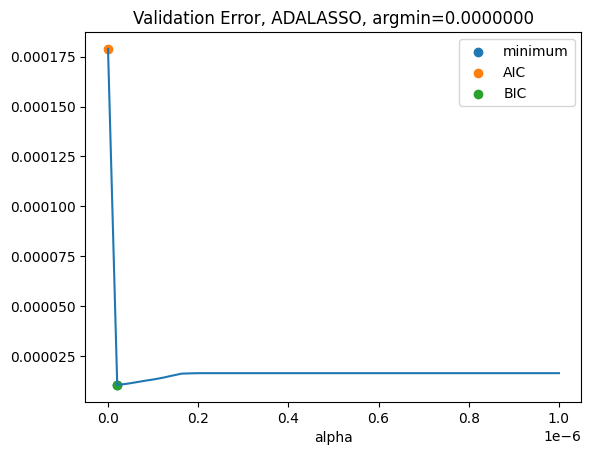

The RMSE of Adaptive LASSO is 0.002269
          Variable Estimates
0           T5YFFM -2.987967
1           AAAFFM -1.237937
2       WPSFD49207  2.676948
3        OILPRICEx  3.525796
4      CUSR0000SAD  4.181666
5    CUSR0000SA0L5  5.928368
6            PCEPI   0.76624
7    CPIAUCSL_lag1   0.51676
8    CPIAUCSL_lag4  2.876837
9    CPIAUCSL_lag8   4.22296
10   CPIAUCSL_lag9  1.087315
11  CPIAUCSL_lag10  1.759307


In [9]:
#######################################################################################
###################################   ADALASSO    #####################################
#######################################################################################
X_train_stzd_tilde = X_train_stzd*np.abs(Ridgemodel_dict[min_idx_ridge].coef_)
X_val_stzd_tilde = X_val_stzd*np.abs(Ridgemodel_dict[min_idx_ridge].coef_)
X_test_stzd_tilde = X_test_stzd*np.abs(Ridgemodel_dict[min_idx_ridge].coef_)

# alpha_list = np.linspace(1e-14,0.0001,100)
alpha_list = np.linspace(0,0.000001,50)
val_err = np.zeros((n_val,len(alpha_list)))
AIC = np.zeros((len(alpha_list),))
BIC = np.zeros((len(alpha_list),))
AdaLassomodel_dict = {}
for cv_i, alpha in enumerate(alpha_list):
    AdaLassomodel_dict[cv_i] = Lasso(alpha=alpha, fit_intercept=True,  warm_start=True, random_state=seed)
    AdaLassomodel_dict[cv_i].fit(X_train_stzd_tilde, Y_train)

    DF = np.sum(AdaLassomodel_dict[cv_i].coef_ !=0)
    RSS = np.sum((Y_train-AdaLassomodel_dict[cv_i].predict(X_train_stzd_tilde))**2)
    BIC[cv_i] = n_train*np.log(RSS) + DF*np.log(n_train)
    AIC[cv_i] = n_train*np.log(RSS) + DF*2
    
    Y_hat = AdaLassomodel_dict[cv_i].predict(X_val_stzd_tilde) 
    val_err[:, cv_i] = Y_val.values-Y_hat

min_idx = np.argmin(np.mean(np.array(val_err)**2, axis=0))
val_err_AdaLasso = np.mean(np.array(val_err)**2, axis=0)
AdaLasso_alpha = val_err_AdaLasso[min_idx]


min_idx_AIC = np.argmin(AIC)
min_idx_BIC = np.argmin(BIC)

plt.plot(alpha_list, val_err_AdaLasso)
plt.scatter(alpha_list[min_idx],val_err_AdaLasso[min_idx],label='minimum')
plt.scatter(alpha_list[min_idx_AIC],val_err_AdaLasso[min_idx_AIC],label='AIC')
plt.scatter(alpha_list[min_idx_BIC],val_err_AdaLasso[min_idx_BIC],label='BIC')
plt.legend()
plt.xlabel('alpha')
plt.title('Validation Error, ADALASSO, argmin=%0.7f'%alpha_list[min_idx])
plt.show()

Y_hat = AdaLassomodel_dict[min_idx].predict(X_test_stzd_tilde)
test_err_AdaLasso = Y_test.values - Y_hat
RMSE_AdaLasso = np.sqrt(np.sum(test_err_AdaLasso**2)/len(test_err_AdaLasso))
print('The RMSE of Adaptive LASSO is %f'%RMSE_AdaLasso)


AdaLasso_df = np.sum(AdaLassomodel_dict[min_idx].coef_ !=0)

nonzero_beta = pd.DataFrame(((X_train_stzd.columns[AdaLassomodel_dict[min_idx].coef_ !=0],
                            AdaLassomodel_dict[min_idx].coef_[AdaLassomodel_dict[min_idx].coef_ !=0]))).T
nonzero_beta.columns = ['Variable','Estimates']
print(nonzero_beta)


# Partially Linear Models

In [10]:
num_lags = 1
V_used = X_used[np.append(['CPIAUCSL'],['CPIAUCSL_lag%i' % p for p in range(1,num_lags)])]
W_used = X_used.drop(np.append(['CPIAUCSL'],['CPIAUCSL_lag%i' % p for p in range(1,12)]),axis=1)

n = X_used.shape[0]

forecast_period = pd.to_datetime('2015-01-01')<=Date_used
forecast_idx = np.where(forecast_period)[0]
n_test = np.sum(forecast_period)

validation_period = (pd.to_datetime('2005-08-01')<=Date_used) & (pd.to_datetime('2015-01-01') > Date_used)
validation_idx = np.where(validation_period)[0]
n_val = np.sum(validation_period)

training_period = pd.to_datetime('2005-08-01')>Date_used
training_idx = np.where(training_period)[0]
n_train = np.sum(training_period)


V_train = V_used.loc[training_period]
W_train = W_used.loc[training_period,:]
Y_train = Y_used.loc[training_period]

V_val = V_used.loc[validation_period]
W_val = W_used.loc[validation_period,:]
Y_val = Y_used.loc[validation_period]

V_test = V_used.loc[forecast_period]
W_test = W_used.loc[forecast_period,:]
Y_test = Y_used.loc[forecast_period]

nnan_idx = np.sum(np.isnan(W_used),axis=0)==0
W_used_nnan = W_used.loc[:,nnan_idx]

W_train_nnan = W_used_nnan.loc[training_period,:]
W_val_nnan = W_used_nnan.loc[validation_period,:]
W_test_nnan = W_used_nnan.loc[forecast_period,:]

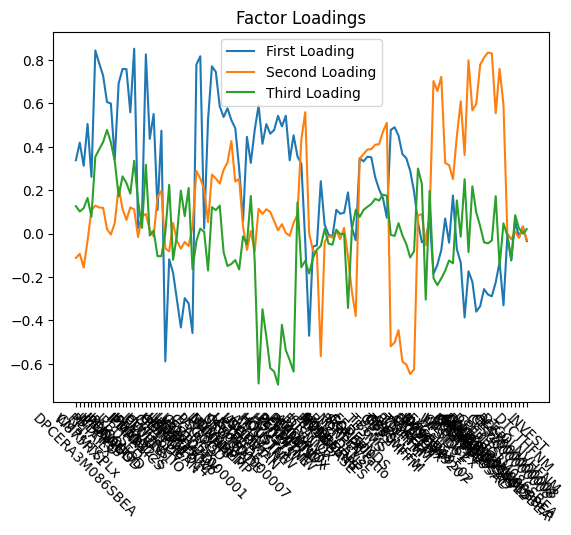

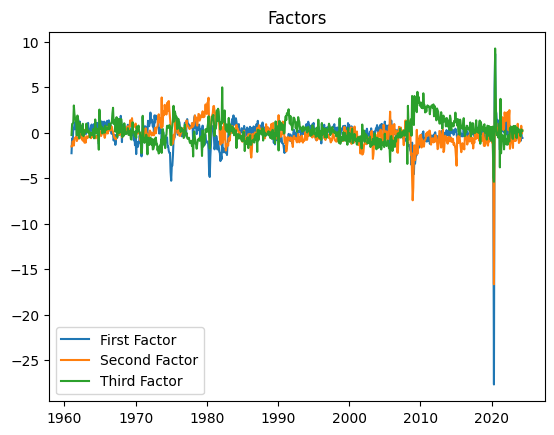

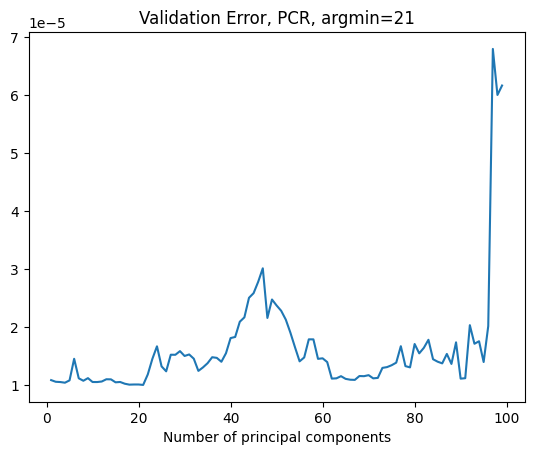

The RMSE of PCR is 0.002565


In [11]:
#######################################################################################
####################################   PCR    #########################################
#######################################################################################
W_train_stzd = (W_train_nnan - np.mean(W_train_nnan, axis=0))/np.std(W_train_nnan, axis = 0)
W_val_stzd = (W_val_nnan - np.mean(W_train_nnan, axis=0))/np.std(W_train_nnan, axis = 0)
W_test_stzd = (W_test_nnan - np.mean(W_train_nnan, axis=0))/np.std(W_train_nnan, axis = 0)    

Sigma_hat = W_train_stzd.T@W_train_stzd/n_train
eigval, eigvec = np.linalg.eigh(Sigma_hat)
eigval = np.real(eigval)
eigvec = np.real(eigvec)
idx = eigval.argsort()[::-1]
eigval_sorted = eigval[idx]
eigvec_sorted = eigvec[:, idx]
F_train = W_train_stzd @ eigvec_sorted
F_val = W_val_stzd @ eigvec_sorted
F_val.columns = F_train.columns
F_test = W_test_stzd @ eigvec_sorted
F_test.columns = F_test.columns


plt.plot(W_train_stzd.columns, eigvec_sorted[:,0]*np.sqrt(eigval_sorted)[0], label='First Loading')
plt.plot(W_train_stzd.columns, eigvec_sorted[:,1]*np.sqrt(eigval_sorted)[1], label='Second Loading')
plt.plot(W_train_stzd.columns, eigvec_sorted[:,2]*np.sqrt(eigval_sorted)[2], label='Third Loading')
plt.xticks(rotation=-45)
plt.title('Factor Loadings')
plt.legend()
plt.show()

plt.plot(Date_used,pd.concat((F_train.iloc[:,0],F_val.iloc[:,0],F_test.iloc[:,0]),axis=0)*(1/np.sqrt(eigval_sorted)[0]), label='First Factor')
plt.plot(Date_used,pd.concat((F_train.iloc[:,1],F_val.iloc[:,1],F_test.iloc[:,1]),axis=0)*(1/np.sqrt(eigval_sorted)[1]), label='Second Factor')
plt.plot(Date_used,pd.concat((F_train.iloc[:,2],F_val.iloc[:,2],F_test.iloc[:,2]),axis=0)*(1/np.sqrt(eigval_sorted)[2]), label='Third Factor')
plt.title('Factors')
plt.legend()
plt.show()


nfactors_list = np.arange(1,100)
val_err = np.zeros((n_val, len(nfactors_list)))
nfactors = 2
PCR_dict = {}
beta_dict_PCR = {}
for cv_i, nfactors in enumerate(nfactors_list):

    PCR_dict[cv_i] = LinearRegression(fit_intercept=True)
    PCR_dict[cv_i].fit(np.concatenate((V_train.values.reshape(-1,1),F_train.iloc[:,:nfactors]),axis=1), Y_train)
    
    Y_hat = PCR_dict[cv_i].predict(np.concatenate((V_val.values.reshape(-1,1),F_val.iloc[:,:nfactors]),axis=1))
    
    beta_dict_PCR[cv_i] = PCR_dict[cv_i].coef_[:1]
    val_err[:, cv_i] = Y_val.values-Y_hat

min_idx = np.argmin(np.mean(np.array(val_err)**2, axis=0))
val_err_PCR = np.mean(np.array(val_err)**2, axis=0)
PL_PCR_nfactors = nfactors_list[min_idx]

plt.plot(nfactors_list, val_err_PCR)
plt.xlabel('Number of principal components')
plt.title('Validation Error, PCR, argmin=%i'%nfactors_list[min_idx])
plt.show()

Y_hat = PCR_dict[min_idx].predict(np.concatenate((V_test.values.reshape(-1,1),F_test.iloc[:,:nfactors_list[min_idx]]),axis=1))
test_err_PL_PCR = Y_test.values - Y_hat
RMSE_PL_PCR = np.sqrt(np.sum(test_err_PL_PCR**2)/len(test_err_PL_PCR))
print('The RMSE of PCR is %f'%RMSE_PL_PCR)

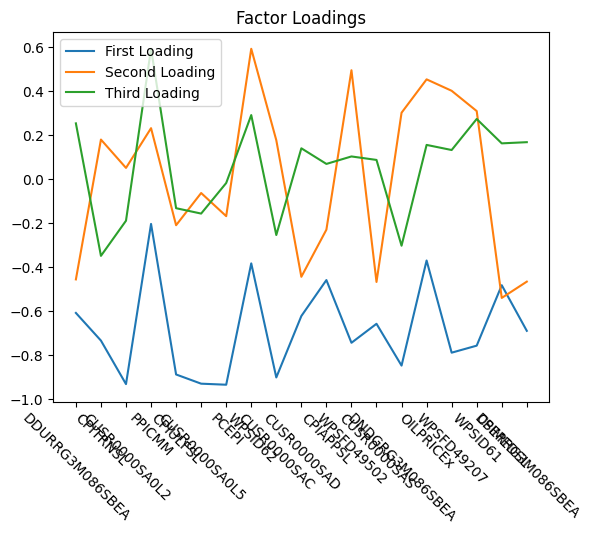

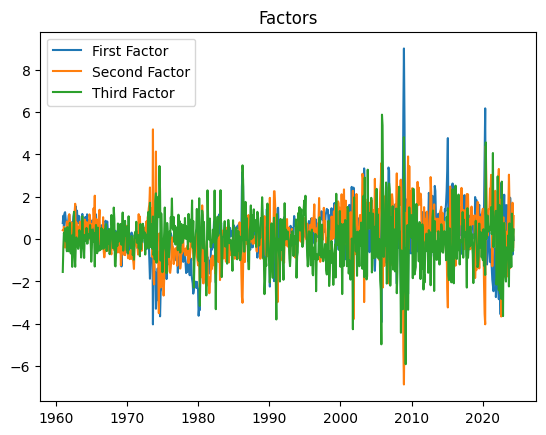

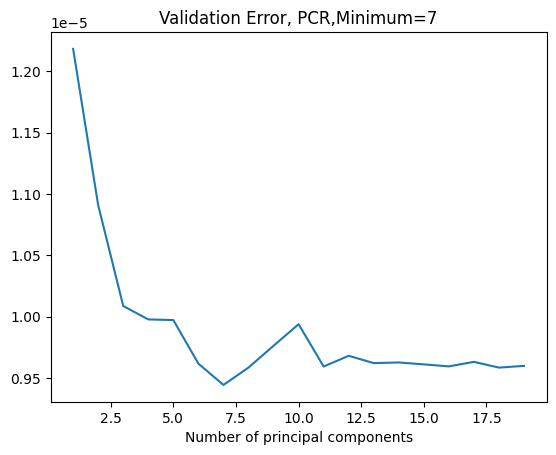

The RMSE of PCR is 0.002385


In [12]:
#######################################################################################
####################################   PCRp    #########################################
#######################################################################################
W_train_stzd2 = (W_train_nnan - np.mean(W_train_nnan, axis=0))/np.std(W_train_nnan, axis = 0)
W_val_stzd2 = (W_val_nnan - np.mean(W_train_nnan, axis=0))/np.std(W_train_nnan, axis = 0)
W_test_stzd2 = (W_test_nnan - np.mean(W_train_nnan, axis=0))/np.std(W_train_nnan, axis = 0)

W_train_stzd = W_train_stzd2[list(set(W_train_stzd2.columns).intersection(set(price_var)))]
W_val_stzd = W_val_stzd2[list(set(W_train_stzd2.columns).intersection(set(price_var)))]
W_test_stzd = W_test_stzd2[list(set(W_train_stzd2.columns).intersection(set(price_var)))]

Sigma_hat = W_train_stzd.T@W_train_stzd/n_train
eigval, eigvec = np.linalg.eigh(Sigma_hat)
eigval = np.real(eigval)
eigvec = np.real(eigvec)
idx = eigval.argsort()[::-1]
eigval_sorted = eigval[idx]
eigvec_sorted = eigvec[:, idx]
F_train = W_train_stzd @ eigvec_sorted
F_val = W_val_stzd @ eigvec_sorted
F_val.columns = F_train.columns
F_test = W_test_stzd @ eigvec_sorted
F_test.columns = F_test.columns


plt.plot(W_train_stzd.columns, eigvec_sorted[:,0]*np.sqrt(eigval_sorted)[0], label='First Loading')
plt.plot(W_train_stzd.columns, eigvec_sorted[:,1]*np.sqrt(eigval_sorted)[1], label='Second Loading')
plt.plot(W_train_stzd.columns, eigvec_sorted[:,2]*np.sqrt(eigval_sorted)[2], label='Third Loading')
plt.xticks(rotation=-45)
plt.title('Factor Loadings')
plt.legend()
plt.show()

plt.plot(Date_used,pd.concat((F_train.iloc[:,0],F_val.iloc[:,0],F_test.iloc[:,0]),axis=0)*(1/np.sqrt(eigval_sorted)[0]), label='First Factor')
plt.plot(Date_used,pd.concat((F_train.iloc[:,1],F_val.iloc[:,1],F_test.iloc[:,1]),axis=0)*(1/np.sqrt(eigval_sorted)[1]), label='Second Factor')
plt.plot(Date_used,pd.concat((F_train.iloc[:,2],F_val.iloc[:,2],F_test.iloc[:,2]),axis=0)*(1/np.sqrt(eigval_sorted)[2]), label='Third Factor')
plt.title('Factors')
plt.legend()
plt.show()


nfactors_list = np.arange(1,20)
val_err = np.zeros((n_val, len(nfactors_list)))
nfactors = 2
PCRp_dict = {}
beta_dict_PCRp = {}
for cv_i, nfactors in enumerate(nfactors_list):

    PCRp_dict[cv_i] = LinearRegression(fit_intercept=True)
    PCRp_dict[cv_i].fit(np.concatenate((V_train.values.reshape(-1,1),F_train.iloc[:,:nfactors]),axis=1), Y_train)
    
    Y_hat = PCRp_dict[cv_i].predict(np.concatenate((V_val.values.reshape(-1,1),F_val.iloc[:,:nfactors]),axis=1))
    
    beta_dict_PCRp[cv_i] = PCRp_dict[cv_i].coef_[:1]
    val_err[:, cv_i] = Y_val.values-Y_hat

min_idx = np.argmin(np.mean(np.array(val_err)**2, axis=0))
val_err_PCRp = np.mean(np.array(val_err)**2, axis=0)
PL_PCRp_nfactors = nfactors_list[min_idx]

plt.plot(nfactors_list, val_err_PCRp)
plt.xlabel('Number of principal components')
plt.title('Validation Error, PCR,Minimum=%i'%nfactors_list[min_idx])
plt.show()

Y_hat = PCRp_dict[min_idx].predict(np.concatenate((V_test.values.reshape(-1,1),F_test.iloc[:,:nfactors_list[min_idx]]),axis=1))
test_err_PL_PCRp = Y_test.values - Y_hat
RMSE_PL_PCRp = np.sqrt(np.sum(test_err_PL_PCRp**2)/len(test_err_PL_PCRp))
print('The RMSE of PCR is %f'%RMSE_PL_PCRp)

## RMSE Comparisons

In [13]:
AR1 = LinearRegression(fit_intercept=True)
AR1.fit(X_train[['CPIAUCSL']], Y_train)
Y_hat = AR1.predict(X_test[['CPIAUCSL']])
test_err_AR1 = Y_test.values - Y_hat
RMSE_AR1 = np.sqrt(np.sum(test_err_AR1**2)/len(test_err_AR1))

lags_label = np.append(['CPIAUCSL'],['CPIAUCSL_lag%i' % p for p in range(1,12)])
AR12 = LinearRegression(fit_intercept=True)
AR12.fit(X_train[lags_label], Y_train)
Y_hat = AR12.predict(X_test[lags_label])
test_err_AR12 = Y_test.values - Y_hat
RMSE_AR12 = np.sqrt(np.sum(test_err_AR12**2)/len(test_err_AR12))

Y_hat = Lassomodel_dict[val_err_Lasso.argmin()].predict(X_test_stzd)
test_err_Lasso = Y_test.values - Y_hat
RMSE_Lasso = np.sqrt(np.sum(test_err_Lasso**2)/len(test_err_Lasso))
print('The RMSE of LASSO is %f'%RMSE_Lasso)
print('The RMSE of AR1 model is %f'%RMSE_AR1)
print('The RMSE of AR12 model is %f'%RMSE_AR12)

The RMSE of LASSO is 0.002253
The RMSE of AR1 model is 0.002456
The RMSE of AR12 model is 0.002445


In [14]:
AR1_rlt = [1,RMSE_AR1]
AR12_rlt = [12,RMSE_AR12]
RW_rlt = ['', RMSE_RW]
RA_rlt = [average_n, RMSE_RA]
PCR_rlt = [PCR_nfactors, RMSE_PCR]
Ridge_rlt = [Ridge_alpha, RMSE_Ridge]
LASSO_rlt = ['%f, df=%i'%(Lasso_alpha,Lasso_df), RMSE_Lasso]
AdaLasso_rlt = ['%f, df=%i'%(AdaLasso_alpha,AdaLasso_df), RMSE_AdaLasso]
PL_PCR_rlt = [PL_PCR_nfactors, RMSE_PL_PCR]
PL_PCRp_rlt = [PL_PCRp_nfactors, RMSE_PL_PCRp]

RESULTS = [AR1_rlt,AR12_rlt,RW_rlt,RA_rlt, PCR_rlt, Ridge_rlt, LASSO_rlt, AdaLasso_rlt, PL_PCR_rlt, PL_PCRp_rlt]
RESULTS_pd = pd.DataFrame(RESULTS)
RESULTS_pd.columns = ['parameters','RMSE']
RESULTS_pd.index = ['AR1','AR12','RW','RA','PCR','Ridge','LASSO','AdaLASSO','PL_PCR','PL_PCRp']
display(RESULTS_pd)

,parameters,RMSE
AR1,1,0.002456
AR12,12,0.002445
RW,,0.002753
RA,36,0.002886
PCR,20,0.002326
Ridge,2040.816327,0.002286
LASSO,"0.000163, df=29",0.002253
AdaLASSO,"0.000010, df=12",0.002269
PL_PCR,21,0.002565
PL_PCRp,7,0.002385


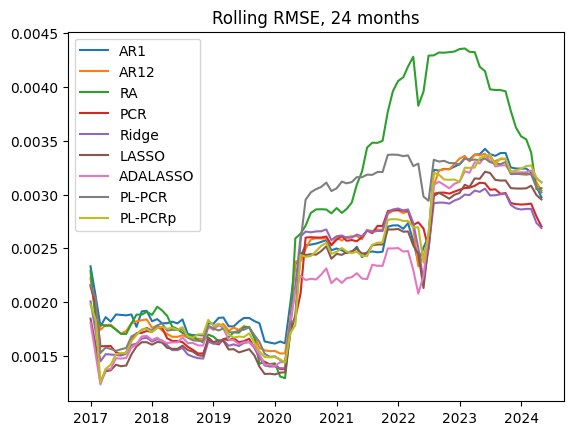

In [15]:
rolling_RMSE_AR1 = np.zeros((n_test-24,))
rolling_RMSE_AR12 = np.zeros((n_test-24,))
rolling_RMSE_RA = np.zeros((n_test-24,))
rolling_RMSE_PCR = np.zeros((n_test-24,))
rolling_RMSE_Ridge = np.zeros((n_test-24,))
rolling_RMSE_LASSO = np.zeros((n_test-24,))
rolling_RMSE_ADALASSO = np.zeros((n_test-24,))
rolling_RMSE_PL_PCR = np.zeros((n_test-24,))
rolling_RMSE_PL_PCRp = np.zeros((n_test-24,))
for j in range(n_test-24):
    rolling_RMSE_AR1[j] = np.sqrt(np.sum(test_err_AR1[j:j+24]**2)/24)
    rolling_RMSE_AR12[j] = np.sqrt(np.sum(test_err_AR12[j:j+24]**2)/24)
    rolling_RMSE_RA[j] = np.sqrt(np.sum(test_err_RA[j:j+24]**2)/24)
    rolling_RMSE_PCR[j] = np.sqrt(np.sum(test_err_PCR[j:j+24]**2)/24)
    rolling_RMSE_Ridge[j] = np.sqrt(np.sum(test_err_Ridge[j:j+24]**2)/24)
    rolling_RMSE_LASSO[j] = np.sqrt(np.sum(test_err_Lasso[j:j+24]**2)/24)
    rolling_RMSE_ADALASSO[j] = np.sqrt(np.sum(test_err_AdaLasso[j:j+24]**2)/24)
    rolling_RMSE_PL_PCR[j] = np.sqrt(np.sum(test_err_PL_PCR[j:j+24]**2)/24)
    rolling_RMSE_PL_PCRp[j] = np.sqrt(np.sum(test_err_PL_PCRp[j:j+24]**2)/24)

# training_idx = np.where(training_period)[0]

plt.plot(Date_used[forecast_period][24:],rolling_RMSE_AR1,label='AR1')
plt.plot(Date_used[forecast_period][24:],rolling_RMSE_AR12,label='AR12')
plt.plot(Date_used[forecast_period][24:],rolling_RMSE_RA,label='RA')
plt.plot(Date_used[forecast_period][24:],rolling_RMSE_PCR,label='PCR')
plt.plot(Date_used[forecast_period][24:],rolling_RMSE_Ridge,label='Ridge')
plt.plot(Date_used[forecast_period][24:],rolling_RMSE_LASSO,label='LASSO')
plt.plot(Date_used[forecast_period][24:],rolling_RMSE_ADALASSO,label='ADALASSO')
plt.plot(Date_used[forecast_period][24:],rolling_RMSE_PL_PCR,label='PL-PCR')
plt.plot(Date_used[forecast_period][24:],rolling_RMSE_PL_PCRp,label='PL-PCRp')
plt.title('Rolling RMSE, 24 months')
plt.legend()
plt.show()

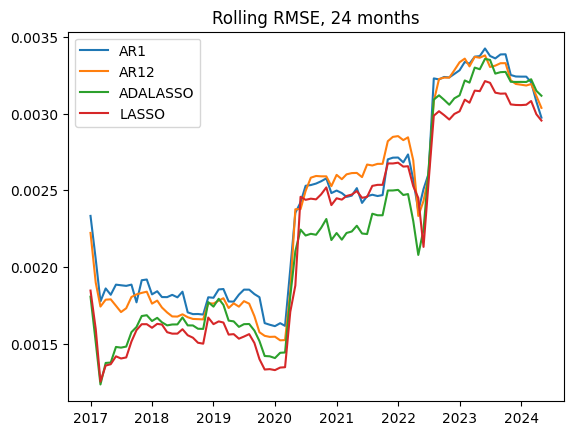

In [16]:


plt.plot(Date_used[forecast_period][24:],rolling_RMSE_AR1,label='AR1')
plt.plot(Date_used[forecast_period][24:],rolling_RMSE_AR12,label='AR12')
plt.plot(Date_used[forecast_period][24:],rolling_RMSE_ADALASSO,label='ADALASSO')
plt.plot(Date_used[forecast_period][24:],rolling_RMSE_LASSO,label='LASSO')
plt.title('Rolling RMSE, 24 months')
plt.legend()
plt.show()

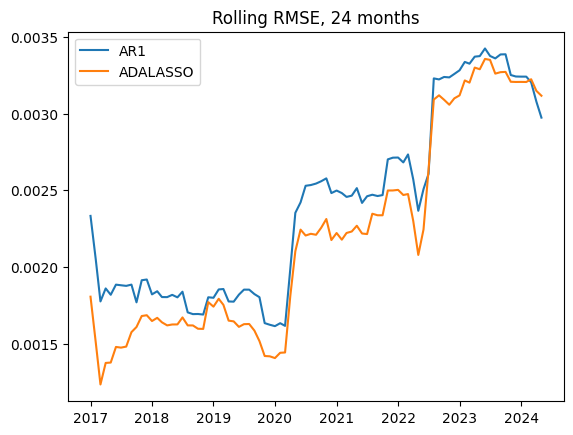

In [17]:
plt.plot(Date_used[forecast_period][24:],rolling_RMSE_AR1,label='AR1')
# plt.plot(Date_used[forecast_period][24:],rolling_RMSE_AR12,label='AR12')
plt.plot(Date_used[forecast_period][24:],rolling_RMSE_ADALASSO,label='ADALASSO')
# plt.plot(Date_used[forecast_period][24:],rolling_RMSE_LASSO,label='LASSO')
plt.title('Rolling RMSE, 24 months')
plt.legend()
plt.show()